In [ ]:
# Install required packages
!pip install opendatasets torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:


import opendatasets as od
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import numpy as np
import copy

In [ ]:


# Download dataset
dataset_url = "https://www.kaggle.com/datasets/msambare/fer2013"
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ishab123 
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


100%|██████████| 60.3M/60.3M [00:03<00:00, 16.3MB/s]


In [ ]:

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)


Using Device: cuda


In [ ]:

# Set up data directories
base_dir = '/content/fer2013'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


In [ ]:

# Enhanced data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.1)
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [ ]:

# Load and split datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


In [ ]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:

# Modified ResNet50 with dropout
class EmotionResNet(nn.Module):
    def __init__(self, num_classes):
        super(EmotionResNet, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Modify the final layers
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # Add dropout to some intermediate layers
        self.resnet.layer3.add_module('dropout', nn.Dropout(0.2))
        self.resnet.layer4.add_module('dropout', nn.Dropout(0.2))

    def forward(self, x):
        return self.resnet(x)


In [ ]:

# Initialize model
num_classes = len(train_dataset.dataset.classes)
model = EmotionResNet(num_classes).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


In [ ]:

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


In [ ]:

# Optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


In [ ]:

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0

# Training and validation function
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    early_stopping = EarlyStopping(patience=3)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Update learning rate
        scheduler.step(val_accuracy)

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

    #     # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)

            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved as best_model.pth")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies


# Train the model
num_epochs = 100
metrics = train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
train_losses, train_accuracies, val_losses, val_accuracies = metrics


KeyboardInterrupt: 

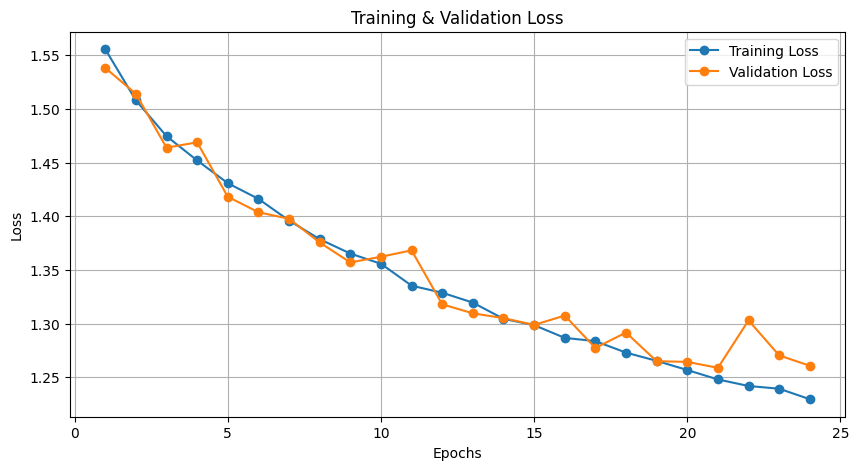

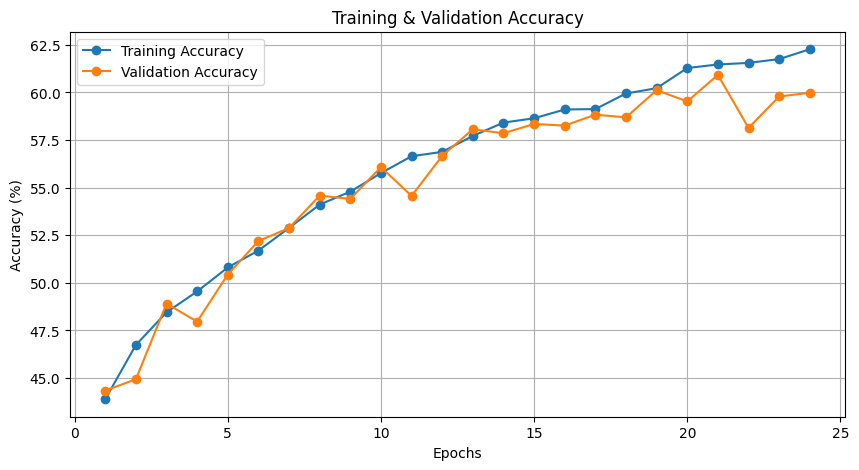

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import files
files.download("/content/best_model.pth")



FileNotFoundError: Cannot find file: /content/best_model.pth